In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# load image as ndarray

http://scikit-image.org/

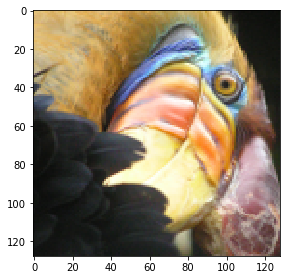

In [4]:
from skimage import io

# cast to float, you need to do this otherwise the color would be weird after clustering
pic = io.imread('data/bird_small.png')/255.
io.imshow(pic)

In [5]:
pic.shape

(128, 128, 3)

In [6]:
# serialize data
data = pic.reshape(128*128, 3)

# let's do k-mean

* my version will take more than 10 mins... ok. I know why I shouldn't implement my own ML library.
* In the future I will only implement ML algorithm for the sake of learning it XD

In [18]:
def k_means(data, k, epoch = 100, n_init = 10):
    """do multiple random init and pick the best one to return 
    Args:
        data (pd.DataFrame)
    Returns:
        (C, centroids, least_cost)
    """
    tries = np.array([_k_means_iter(data, k, epoch) for _ in range(n_init)], dtype = object)
    
    least_cost_idx = np.argmin(tries[:, -1])
    
    return tries[least_cost_idx]

In [19]:
# support fn --------------------------------
def combine_data_C(data, C):
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c


# k-means fn --------------------------------
def random_init(data, k):
    """choose k sample from data set as init centroids
    Args:
        data: DataFrame
        k: int
    Returns:
        k samples: ndarray
    """
    return data.sample(k).values


def _find_your_cluster(x, centroids):
    """find the right cluster for x with respect to shortest distance
    Args:
        x: ndarray (n, ) -> n features
        centroids: ndarray (k, n)
    Returns:
        k: int
    """
    distances = np.apply_along_axis(func1d=np.linalg.norm,  # this give you l2 norm
                                    axis=1,
                                    arr=centroids - x)  # use ndarray's broadcast
    return np.argmin(distances)


def assign_cluster(data, centroids):
    """assign cluster for each node in data
    return C ndarray
    """
    return np.apply_along_axis(lambda x: _find_your_cluster(x, centroids),
                               axis=1,
                               arr=data.values)


def new_centroids(data, C):
    data_with_c = combine_data_C(data, C)

    return data_with_c.groupby('C', as_index=False).\
                       mean().\
                       sort_values(by='C').\
                       drop('C', axis=1).\
                       values


def cost(data, centroids, C):
    m = data.shape[0]

    expand_C_with_centroids = centroids[C]

    distances = np.apply_along_axis(func1d=np.linalg.norm,
                                    axis=1,
                                    arr=data.values - expand_C_with_centroids)
    return distances.sum() / m


def _k_means_iter(data, k, epoch=100, tol=0.0001):
    """one shot k-means
    with early break
    """
    centroids = random_init(data, k)
    cost_progress = []

    for i in range(epoch):
        print('running epoch {}'.format(i))

        C = assign_cluster(data, centroids)
        centroids = new_centroids(data, C)
        cost_progress.append(cost(data, centroids, C))

        if len(cost_progress) > 1:  # early break
            if (np.abs(cost_progress[-1] - cost_progress[-2])) / cost_progress[-1] < tol:
                break

    return C, centroids, cost_progress[-1]

In [20]:
C, centroids, cost = k_means(pd.DataFrame(data), 16, epoch = 10, n_init = 3)

running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9
running epoch 0
running epoch 1
running epoch 2
running epoch 3
running epoch 4
running epoch 5
running epoch 6
running epoch 7
running epoch 8
running epoch 9


# sklearn KMeans

In [23]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters = 16, n_init = 100)

In [24]:
model.fit(data)

KMeans(n_clusters=16, n_init=100)

In [25]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [26]:
centroids[C].shape

(16384, 3)

In [27]:
compressed_pic = centroids[C].reshape((128, 128, 3))

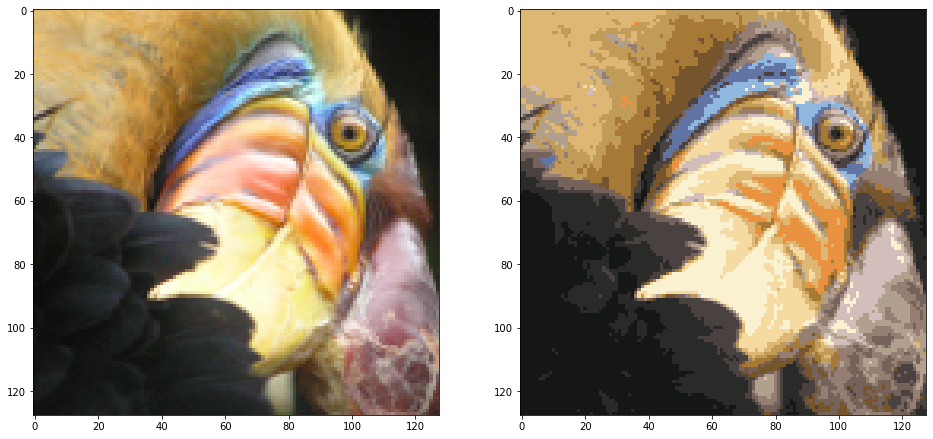

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()